# Drone Detection Project: Deep Learning

This project focuses on image recognition using deep learning techniques. The objective is to develop a model that classifies images into three categories: drones, birds, and helicopters. The images are pre-sorted into three distinct groups according to their respective categories. The model is designed to accurately classify the images based on visual information and involves stages of preprocessing, model training, and performance evaluation on a designated test dataset.

* Loading the data from the drive:
445 drones, 478 birds, 463 helicopters =1386
* Cleaning and arranging the data:
The data is balanced. We will have to normalize the data and convert the label to ONE HOT ENCODER.
* Defining functions
* Experimenting with different models.
*Accuracy Comparison


Sources:
* https://www.kaggle.com/datasets/harshwalia/bird-vs-drone-new/data
* https://www.kaggle.com/datasets/eabdul/flying-vehicles/data

Link to dataset: https://drive.google.com/drive/folders/1fAteITxhftYMU0UTWf7Ke0k-fpUCOhQu?usp=sharing

**Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**import related libraries**

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**load the data**

In [ ]:
#path to the folder of images in google drive
base_dir = '/content/drive/MyDrive/dataset'

#define labels
labels_map = {'drones': 0, 'birds': 1, 'helicopters': 2}
num_classes = len(labels_map)

In [ ]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            images.append(img)
            labels.append(label)
    return images, labels

In [ ]:
#load drones folder and print info
drones_folder = os.path.join(base_dir, 'drones')
drones_images, drones_labels = load_images_from_folder(drones_folder, labels_map['drones'])

print(f'Loaded {len(drones_images)} images from drones folder.')
print(f'First image shape: {drones_images[0].shape}')
print(f'First label: {drones_labels[0]}')

Loaded 445 images from drones folder.
First image shape: (224, 224, 3)
First label: 0


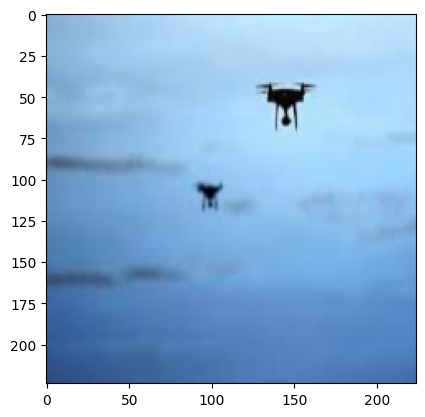

In [ ]:
#drone image for example
%matplotlib inline
plt.imshow(drones_images[400]);

In [ ]:
all_images = []
all_labels = []

for label_name, label_idx in labels_map.items():
    folder_path = os.path.join(base_dir, label_name)
    images, labels = load_images_from_folder(folder_path, label_idx)
    all_images.extend(images)
    all_labels.extend(labels)
    print(f'Loaded {len(images)} images from {label_name} folder.')

# Convert the data to NumPy arrays
x = np.array(all_images)
y = np.array(all_labels)

print(f'Total images: {x.shape[0]}')
print(f'Image shape: {x.shape[1:]}')
print(f'Label distribution: {np.bincount(y)}')

Loaded 445 images from drones folder.
Loaded 478 images from birds folder.
Loaded 463 images from helicopters folder.
Total images: 1386
Image shape: (224, 224, 3)
Label distribution: [445 478 463]


**print examples of images and theie category**

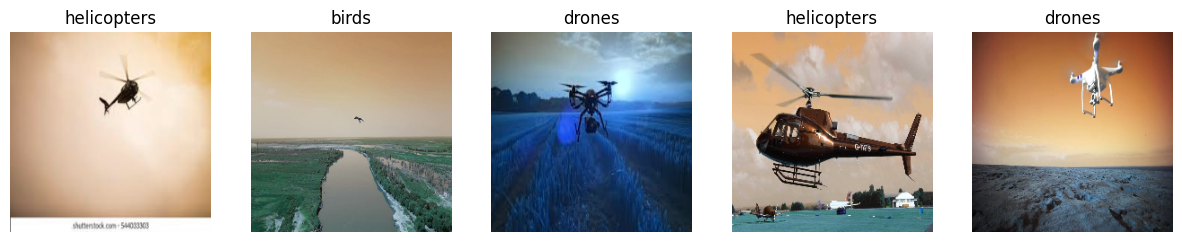

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
indices = random.sample(range(len(x)), 5)

for ax, idx in zip(axes, indices):
  ax.imshow(x[idx])
  label_idx = y[idx]
  label_name = [name for name, idx_ in labels_map.items() if idx_ == label_idx][0]
  ax.set_title(label_name)
  ax.axis('off')

plt.show()

In [ ]:
print(x[555].shape)
print(y[555])

(224, 224, 3)
1


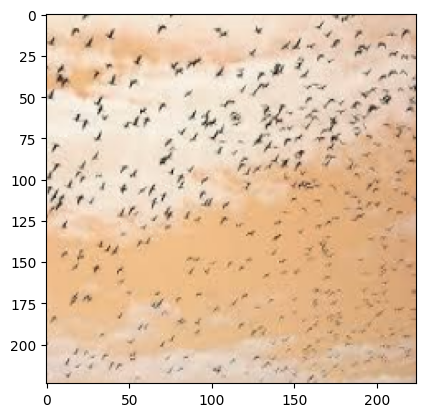

In [ ]:
plt.imshow(x[555]);

**Scaling the data**

In [ ]:
#Data normalization
x = x.astype('float32')
x /= 255

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#Checking sizes and label distribution
print(f'Training set size: {x_train.shape[0]}')
print(f'Test set size: {x_test.shape[0]}')
print(f'Training label distribution: {np.bincount(y_train)}')
print(f'Test label distribution: {np.bincount(y_test)}')

Training set size: 1108
Test set size: 278
Training label distribution: [359 388 361]
Test label distribution: [ 86  90 102]


**One hot encoder label**

In [ ]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y = to_categorical(y, num_classes)
print(y[555])

[0. 1. 0.]


**Functions to use later**

In [ ]:
# Function to plot accuracy and loss graphs
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
def plot_training_history(history, title_suffix):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy over Epochs ({title_suffix})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Set X-axis ticks with step size of 2
    plt.xticks(np.arange(0, len(history.history['accuracy']) + 1, 2))

    # Set Y-axis ticks with step size of 0.05
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss over Epochs ({title_suffix})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Set X-axis ticks with step size of 2
    plt.xticks(np.arange(0, len(history.history['loss']) + 1, 2))

    # Set Y-axis ticks with step size of 0.05
    plt.gca().yaxis.set_major_locator(MultipleLocator(0.05))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

In [ ]:
# Function to display confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    classes = ["drones", "birds", "helicopters"]
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

**Parameters to avoid overfitting**

In [ ]:
# Implement Early Stopping and Reduce Learning Rate on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

**Investigating different models**

# Model 1- CIFAR-10

CIFAR-10 Dataset. This is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes.

**Build the model**

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (5, 5), strides=(2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#present summary model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 54, 54, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 27, 27, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23328)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      11,944,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,974,051 (45.68 MB)

 Trainable params: 11,974,051 (45.68 MB)

 Non-trainable params: 0 (0.00 B)

**Fit the model**

In [ ]:
history_cifar = model.fit(x_train, y_train,
              batch_size=32,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[early_stopping, lr_reduction])

Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.3738 - loss: 1.4821 - val_accuracy: 0.5971 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5753 - loss: 0.9915 - val_accuracy: 0.5791 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6421 - loss: 0.8366 - val_accuracy: 0.6871 - val_loss: 0.7382 - learning_rate: 0.0010
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7392 - loss: 0.6503 - val_accuracy: 0.7014 - val_loss: 0.7634 - learning_rate: 0.0010
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7727 - loss: 0.5780 - val_accuracy: 0.5971 - val_loss: 0.9952 - learning_rate: 0.0010
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8206 - loss: 0.4434 - val_accuracy: 0.7050 - val_loss: 0.8599 - learning_rate: 0.0010
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9031 - loss: 0.2908 - val_ac

**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7069 - loss: 0.6944
Accuracy: 0.6870503425598145, Loss: 0.7381789684295654


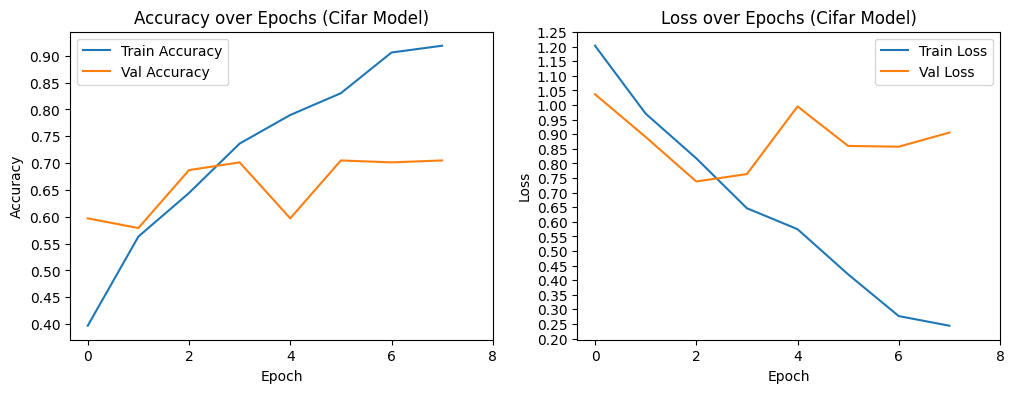

In [ ]:
plot_training_history(history_cifar, 'Cifar Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


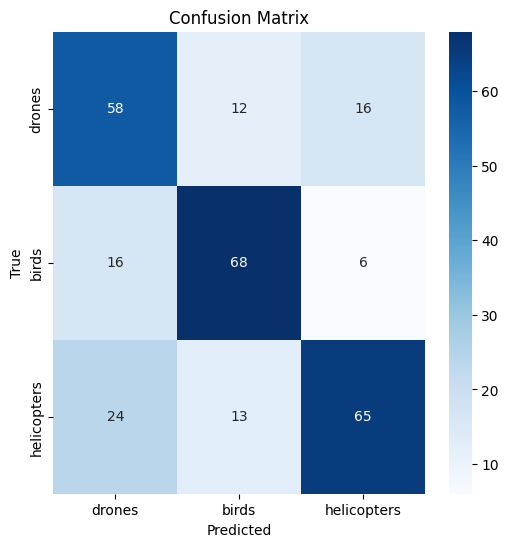

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.59      0.67      0.63        86
       birds       0.73      0.76      0.74        90
 helicopters       0.75      0.64      0.69       102

    accuracy                           0.69       278
   macro avg       0.69      0.69      0.69       278
weighted avg       0.69      0.69      0.69       278



# Model 2 - CNN

CNN model we built

**Build the model**

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  #number of categories by labels_map
])

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#present model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Fit the model**

In [ ]:
history_cnn = model.fit(x_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[early_stopping, lr_reduction])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.3624 - loss: 1.8412 - val_accuracy: 0.5935 - val_loss: 0.8736 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6174 - loss: 0.8584 - val_accuracy: 0.5791 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6331 - loss: 0.8112 - val_accuracy: 0.7086 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7200 - loss: 0.6708 - val_accuracy: 0.7050 - val_loss: 0.6947 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7404 - loss: 0.6501 - val_accuracy: 0.7014 - val_loss: 0.7522 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7694 - loss: 0.5645 - val_accuracy: 0.7230 - val_loss: 0.7088 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7923 - loss: 0.5244 - val_a

**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8185 - loss: 0.5796
Accuracy: 0.7841726541519165, Loss: 0.6652884483337402


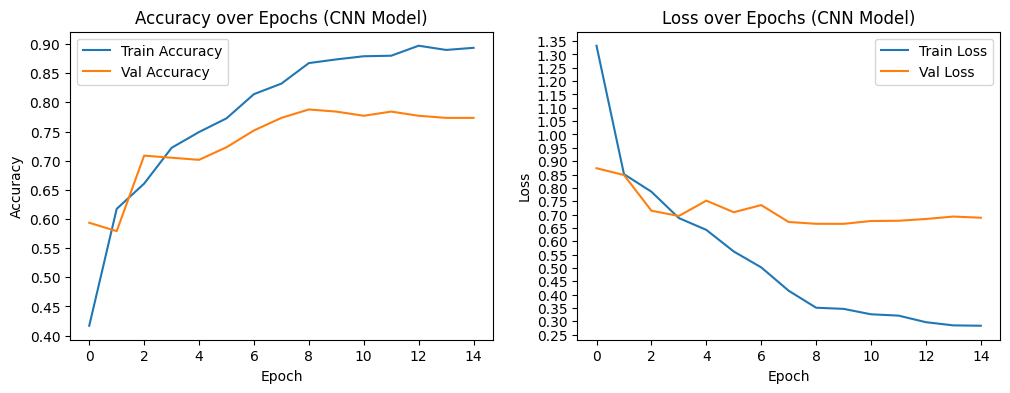

In [ ]:
plot_training_history(history_cnn, 'CNN Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


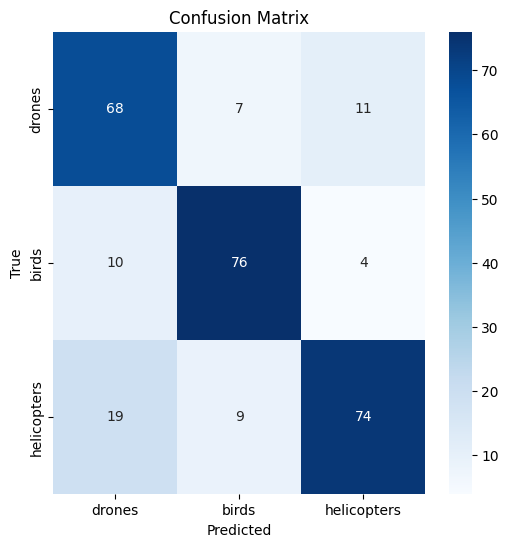

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.70      0.79      0.74        86
       birds       0.83      0.84      0.84        90
 helicopters       0.83      0.73      0.77       102

    accuracy                           0.78       278
   macro avg       0.79      0.79      0.78       278
weighted avg       0.79      0.78      0.78       278



# Model 3 - VGG-16

VGG-16 is a well-known model when you want to use a model that has been tested and proven to be effective in image classification, and can be used as a base model to customize to the specific needs of a project or problem.

**Transfer learning**

In [ ]:
# Load pre-trained VGG16 model + higher level layers
# Base Model Training (Pre-trained, Frozen)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model by passing a sample input
model.build(input_shape=(None, 224, 224, 3))

# Print the model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Fit the model**

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module='keras')
# Train the model
history_VGG = model.fit(x_train, y_train,
              batch_size=32,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[early_stopping, lr_reduction])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4227 - loss: 1.1353 - val_accuracy: 0.6906 - val_loss: 0.7655 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.6641 - loss: 0.7690 - val_accuracy: 0.7662 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.7270 - loss: 0.6555 - val_accuracy: 0.8058 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.7633 - loss: 0.5946 - val_accuracy: 0.8165 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.8171 - loss: 0.5340 - val_accuracy: 0.8273 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.8354 - loss: 0.4605 - val_accuracy: 0.8453 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.8511 - loss: 0.4303 -

**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8580 - loss: 0.3359
Accuracy: 0.8705036044120789, Loss: 0.3266311585903168


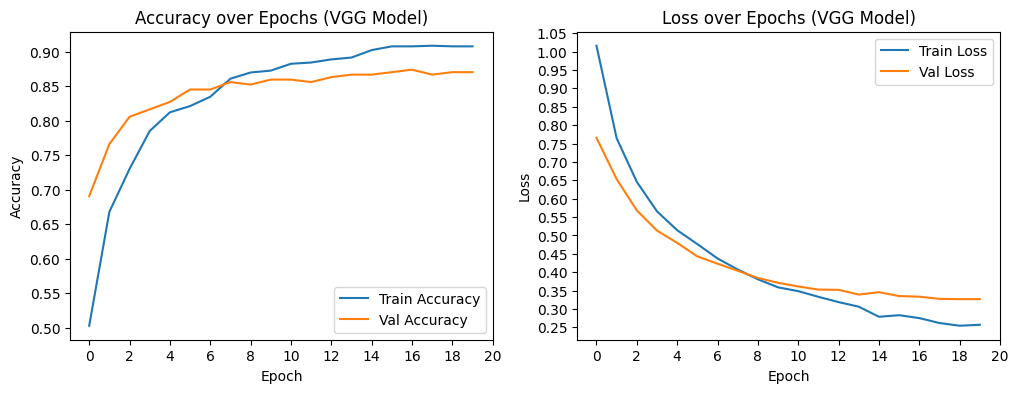

In [ ]:
plot_training_history(history_VGG, 'VGG Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


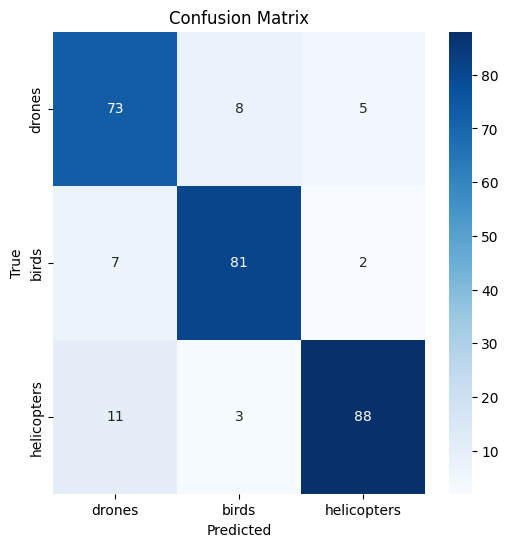

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.80      0.85      0.82        86
       birds       0.88      0.90      0.89        90
 helicopters       0.93      0.86      0.89       102

    accuracy                           0.87       278
   macro avg       0.87      0.87      0.87       278
weighted avg       0.87      0.87      0.87       278



# Model 4 - Fine tuned VGG-16

**Fine Tuning model**

In [ ]:
# Initially freeze all layers
base_model.trainable = False

# Set trainable for layers from 'block5_conv1' and onwards
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model by passing a sample input
model.build(input_shape=(None, 224, 224, 3))

# Print the model summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 7,145,475 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Fit the model**

In [ ]:
# Train the model
history_Fine_tuned_VGG = model.fit(x_train, y_train,
                         batch_size=32,
                         epochs=20,
                         validation_data=(x_test, y_test),
                         shuffle=True,
                         callbacks=[early_stopping, lr_reduction])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 300ms/step - accuracy: 0.9135 - loss: 0.2623 - val_accuracy: 0.8921 - val_loss: 0.2844 - learning_rate: 1.0000e-05
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.9518 - loss: 0.1460 - val_accuracy: 0.8921 - val_loss: 0.2720 - learning_rate: 1.0000e-05
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.9548 - loss: 0.1332 - val_accuracy: 0.9065 - val_loss: 0.2571 - learning_rate: 1.0000e-05
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step - accuracy: 0.9825 - loss: 0.0862 - val_accuracy: 0.9029 - val_loss: 0.2456 - learning_rate: 1.0000e-05
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9864 - loss: 0.0694 - val_accuracy: 0.9029 - val_loss: 0.2608 - learning_rate: 1.0000e-05
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9898 - loss: 0.0488 - val_accuracy: 0.8993 - val_loss: 0.2379 - learning_rate: 1.0000e-05
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy:

**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9039 - loss: 0.2220
Accuracy: 0.8992805480957031, Loss: 0.23786893486976624


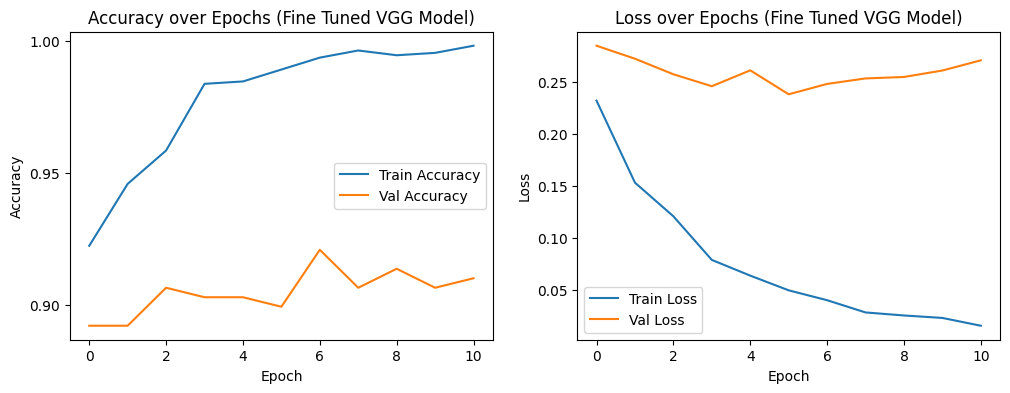

In [ ]:
plot_training_history(history_Fine_tuned_VGG, 'Fine Tuned VGG Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


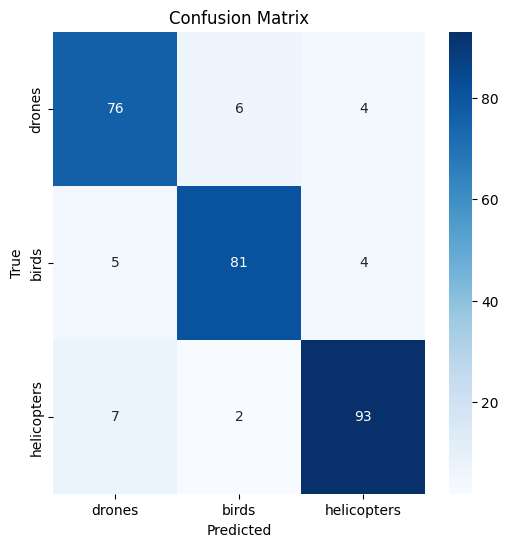

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.86      0.88      0.87        86
       birds       0.91      0.90      0.91        90
 helicopters       0.92      0.91      0.92       102

    accuracy                           0.90       278
   macro avg       0.90      0.90      0.90       278
weighted avg       0.90      0.90      0.90       278



# Model 5 - MobileNet

MobileNet is especially suitable when there is a need for a light and efficient model that does not compromise the quality of performance, especially in situations where it is necessary to operate on limited devices in terms of resources and small datasets.

**Transfer learning**

In [ ]:
# Load pre-trained MobileNetV2 model + higher level layers
# Base Model Training (Pre-trained, Frozen)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model by passing a sample input
model.build(input_shape=(None, 224, 224, 3))

# Print the model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Fit the model**

In [ ]:
# Train the model
history_MobileNet = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    shuffle=True,
                    callbacks=[early_stopping, lr_reduction])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 349ms/step - accuracy: 0.6527 - loss: 0.7505 - val_accuracy: 0.9209 - val_loss: 0.2595 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9285 - loss: 0.2141 - val_accuracy: 0.9353 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9313 - loss: 0.1796 - val_accuracy: 0.9388 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9478 - loss: 0.1338 - val_accuracy: 0.9353 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9603 - loss: 0.1173 - val_accuracy: 0.9460 - val_loss: 0.2076 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9667 - loss: 0.0889 - val_accuracy: 0.9424 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9912 - loss: 0.0449 - val_a

**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9475 - loss: 0.1840
Accuracy: 0.9424460530281067, Loss: 0.20291581749916077


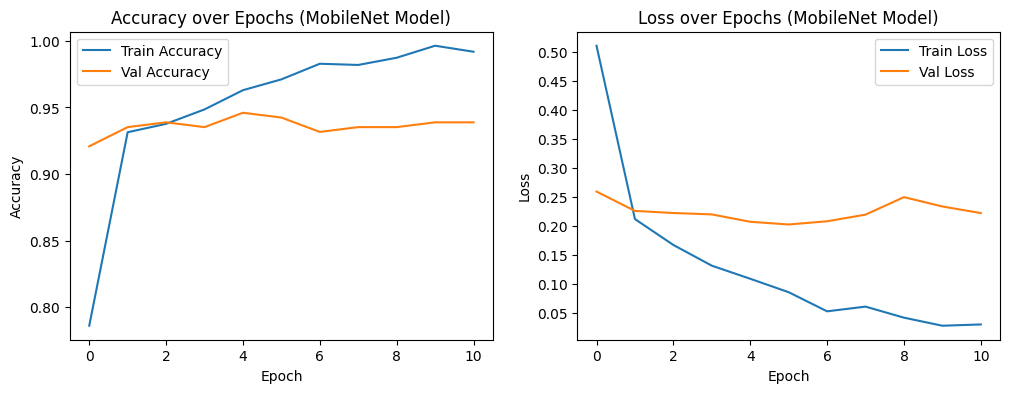

In [ ]:
plot_training_history(history_MobileNet, 'MobileNet Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step


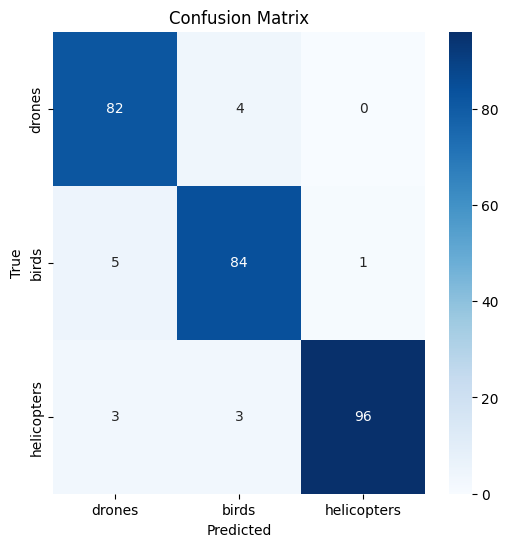

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.91      0.95      0.93        86
       birds       0.92      0.93      0.93        90
 helicopters       0.99      0.94      0.96       102

    accuracy                           0.94       278
   macro avg       0.94      0.94      0.94       278
weighted avg       0.94      0.94      0.94       278



# Model 6 - Fine Tuned MobileNet

**Fine tuning model**

In [ ]:
# ** Step 2: Fine-Tuned Model Training (Pre-trained, Partially Unfrozen) **
from tensorflow.keras.optimizers import Adam
# Unfreeze the last few layers
base_model.trainable = True
fine_tune_at = 100  #unfreeze from the 100th layer

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Build the model by passing a sample input
model.build(input_shape=(None, 224, 224, 3))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,025,795 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

**Fit the model**

In [ ]:
history_fine_tuned_MobileNet = model.fit(x_train, y_train,
                                        batch_size=32,
                                        epochs=20,
                                        validation_data=(x_test, y_test),
                                        shuffle=True,
                                        callbacks=[early_stopping, lr_reduction])

Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step - accuracy: 0.8910 - loss: 0.3219 - val_accuracy: 0.9424 - val_loss: 0.2049 - learning_rate: 1.0000e-05
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9073 - loss: 0.2387 - val_accuracy: 0.9388 - val_loss: 0.2061 - learning_rate: 1.0000e-05
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9246 - loss: 0.1947 - val_accuracy: 0.9388 - val_loss: 0.2083 - learning_rate: 1.0000e-05
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9338 - loss: 0.1640 - val_accuracy: 0.9388 - val_loss: 0.2072 - learning_rate: 1.0000e-05
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9614 - loss: 0.1147 - val_accuracy: 0.9424 - val_loss: 0.2117 - learning_rate: 1.0000e-05


**Show important measures, graphs and confusion matrix**

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {val_accuracy}, Loss: {val_loss}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9479 - loss: 0.1870
Accuracy: 0.9424460530281067, Loss: 0.20485304296016693


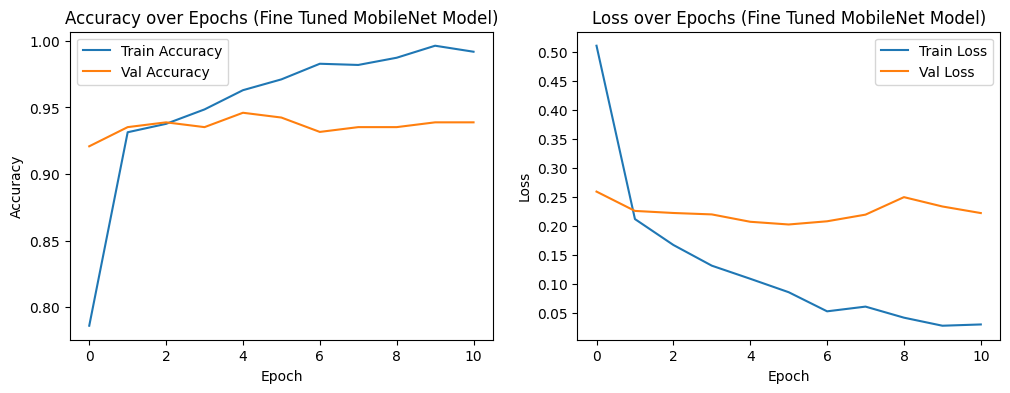

In [ ]:
plot_training_history(history_MobileNet, 'Fine Tuned MobileNet Model')

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step


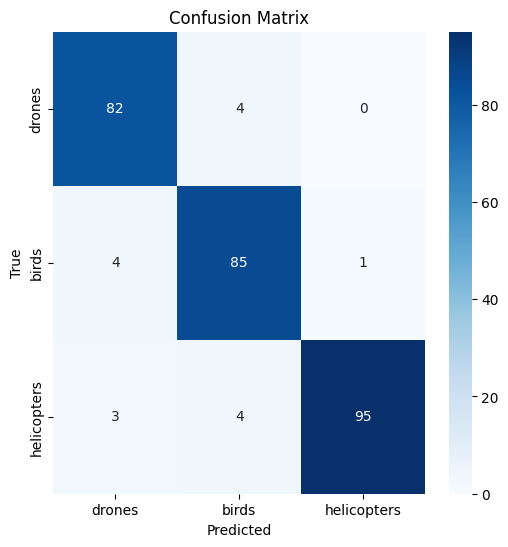

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis=-1)
y_true = np.argmax(y_test, axis=1)  # תוויות האמת
plot_confusion_matrix(y_true, y_pred)

In [ ]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=["drones", "birds", "helicopters"]))

Classification Report
              precision    recall  f1-score   support

      drones       0.92      0.95      0.94        86
       birds       0.91      0.94      0.93        90
 helicopters       0.99      0.93      0.96       102

    accuracy                           0.94       278
   macro avg       0.94      0.94      0.94       278
weighted avg       0.94      0.94      0.94       278



**Accuracy Comparison**

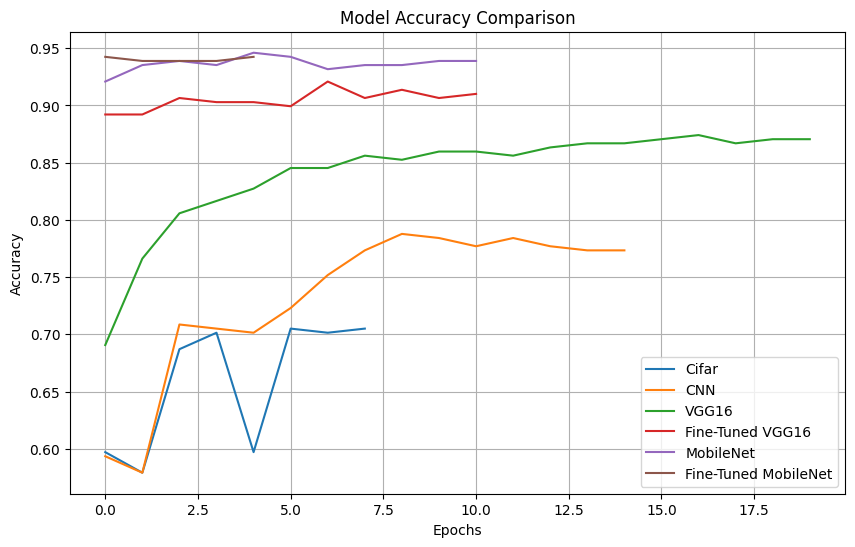

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy from each history object
accuracy_cifar = history_cifar.history['val_accuracy']
accuracy_cnn = history_cnn.history['val_accuracy']
accuracy_vgg16 = history_VGG.history['val_accuracy']
accuracy_fine_tuned_vgg16 = history_Fine_tuned_VGG.history['val_accuracy']
accuracy_mobilenet = history_MobileNet.history['val_accuracy']
accuracy_fine_tuned_mobilenet = history_fine_tuned_MobileNet.history['val_accuracy']

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(accuracy_cifar, label='Cifar')
plt.plot(accuracy_cnn, label='CNN')
plt.plot(accuracy_vgg16, label='VGG16')
plt.plot(accuracy_fine_tuned_vgg16, label='Fine-Tuned VGG16')
plt.plot(accuracy_mobilenet, label='MobileNet')
plt.plot(accuracy_fine_tuned_mobilenet, label='Fine-Tuned MobileNet')

# Adding labels and title
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Accuracy diagram**

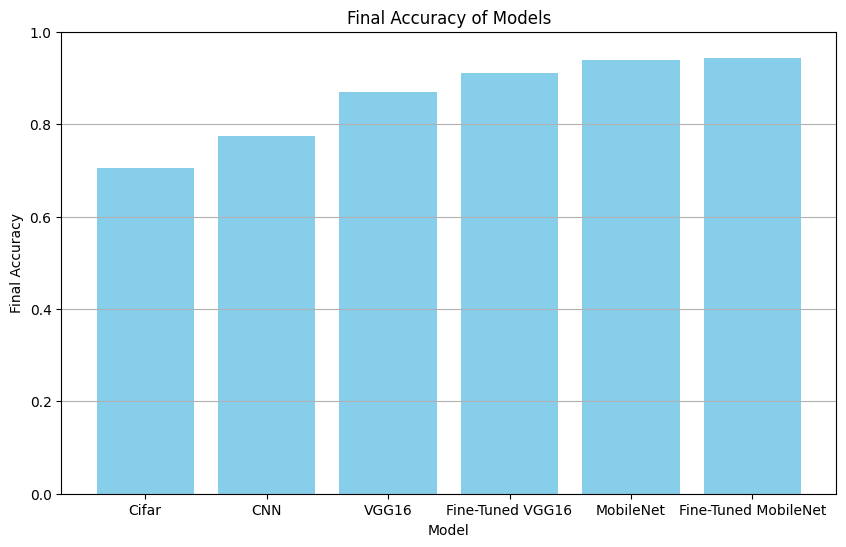

In [ ]:
import matplotlib.pyplot as plt

# Extract the final accuracy from each model's history
final_accuracy_cifar = history_cifar.history['val_accuracy'][-1]
final_accuracy_cnn = history_cnn.history['val_accuracy'][-1]
final_accuracy_vgg16 = history_VGG.history['val_accuracy'][-1]
final_accuracy_fine_tuned_vgg16 = history_Fine_tuned_VGG.history['val_accuracy'][-1]
final_accuracy_mobilenet = history_MobileNet.history['val_accuracy'][-1]
final_accuracy_fine_tuned_mobilenet = history_fine_tuned_MobileNet.history['val_accuracy'][-1]

# List of model names and their corresponding final accuracies
model_names = ['Cifar', 'CNN', 'VGG16', 'Fine-Tuned VGG16', 'MobileNet', 'Fine-Tuned MobileNet']
final_accuracies = [
    final_accuracy_cifar,
    final_accuracy_cnn,
    final_accuracy_vgg16,
    final_accuracy_fine_tuned_vgg16,
    final_accuracy_mobilenet,
    final_accuracy_fine_tuned_mobilenet
]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, final_accuracies, color='skyblue')

# Adding labels and title
plt.title('Final Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Final Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y')
plt.show()

# Summary


- # Model 1
* **CIFAR-10 Model-**
CIFAR-10 Dataset is a well-known dataset for image classification, which consists of 60000 32x32 color images in 10 classes, with 6000 images per class
There are 50000 training images and 10000 test images. The 10 classes are:
[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]
- **Why?** The use of a model based on CIFAR-10 was fitting for classifying our dataset because it’s already trained on small, colorful images containing similar objects like birds and airplanes. The convolutional neural network (CNN) structure of the model is well-suited for classification tasks, and leveraging transfer learning allows to enhance its performance in distinguishing drones, birds, and helicopters in our dataset.
- **Results:** accuracy *0.69*. The ability to classify birds and the helicopters was a little better than the drones. In drones it can be seen that it is more difficult for the model to distinguish between an helicopter and a drone.
- # Model 2
* **CNN Model-** A model with three convolutional layers that we built.
- **Why?** The model is well-suited for classifying our images because it uses convolutional and max-pooling layers to learn complex visual features, combined with flatten and dense layers for accurate final classification. The dropout layer helps prevent overfitting, and the 'adam' optimizer ensures efficient learning. Together, these elements provide a strong foundation for classifying drones, birds, and helicopters.
- **Results:** accuracy *0.78*. There is an improvement in the model's ability to differentiate between the different images. But still he gets a little confused between a drone and a helicopter.
- # Model 3
* **VGG-16 Model-** VGG-16 is a deep convolutional neural network with 16 layers, designed for image classification tasks. It is known for its simplicity and effectiveness in capturing complex visual features through a series of convolutional and pooling layers.
- **Why?** VGG-16 is a deep convolutional neural network with a proven track record in image classification tasks. Its architecture, consisting of 16 layers, is specifically designed to capture intricate visual patterns and features, making it highly effective for distinguishing between objects like drones, birds, and helicopters. Additionally, VGG-16's ability to generalize across various datasets means it can perform well with minimal fine-tuning on our specific dataset, leveraging pre-trained weights for better accuracy.
- **Results:** accuracy *0.87*. There is a more significant improvement in the model's ability to differentiate between the different images.
But still he gets a little confused between a drone and a helicopter.
- # Model 4
* **Fine Tuned VGG-16 Model-** Fine-tuning of the fifth block
- **Why?** Using VGG-16 with fine-tuning of the fifth block is well-suited for classifying our images because it leverages the general knowledge the model has from pre-training on large datasets, while also adapting to the specific features of drones, birds, and helicopters in our dataset. This approach balances general and specific learning, reducing the risk of overfitting and leading to more accurate classification results.
- **Results:** accuracy *0.90*. It can be seen that the tuning of the model helped to improve the performance. There is a more significant improvement in the model's ability to distinguish between the different images.
- # Model 5
* **MobileNet Model-** MobileNet is a lightweight deep learning model designed for efficient image classification, using depthwise separable convolutions to reduce computational complexity while maintaining good performance. It is particularly suited for mobile and edge devices with limited resources.
- **Why?** MobileNet is ideal for our small dataset because of its lightweight and efficient design, which helps it perform well even with limited data and computational resources. Its depthwise separable convolutions allow it to learn complex features without requiring extensive training data, reducing the risk of overfitting and making it a practical choice for classifying drones, birds, and helicopters.
- **Results:** accuracy 0.94. Very significant improvement, good results.
- # Model 6
* **Fine Tuned MobileNet Model-** Fine-tuning the last 100 layers of MobileNet.
- **Why?** Fine-tuning the last 100 layers of MobileNet is effective for our dataset because it allows the model to adapt its deeper features to the specific characteristics of our images while retaining the general knowledge from pre-training. This approach combines the benefits of pre-trained weights with targeted adjustments, improving accuracy while minimizing overfitting through a controlled learning process.
- **Results:** accuracy 0.94. No significant improvement.


Overall, as we progressed with the models, the accuracy improved, and MobileNet emerged as the best model for our dataset. Its efficiency allowed it to achieve the highest performance in classifying drones, birds, and helicopters.